In [1]:
#run the line below if you're on Erda
#pip install keras-tcn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tcn import TCN
from tensorflow import keras
import tensorflow as tf
from sklearn import metrics
from HomemadeFuncs import ROC_plot
import sqlite3
import time
from Dataloader import *

## Parameters

In [3]:
#Note: You want at least ~50k events to see good results
N_muons = 10                         # Number of events to get
N_epochs = 10                        # Number of epochs to train for
N_filters = 32                       # Number of filters in a single network layer
Kernel_size = 2                      # How many datapoints to convolve over
lr = 0.001                           # Learning rate
N_features = 5                       # Number of features in training data
batch_size = 1000                    # Max number of events in one batch
input_shape = (batch_size, None, N_features)
output_dim = 2                       # Output dimensions (probability of stopped, probability of through)

params  = {'optimizer': tf.keras.optimizers.Adam(learning_rate=lr),
           'loss'     : tf.keras.losses.BinaryCrossentropy(),
           'metrics'  : [tf.keras.metrics.AUC() , tf.keras.metrics.BinaryAccuracy()]}

In [5]:
db_file = './rasmus_classification_muon_3neutrino_3mio.db' # The db file containing the events
all_events = pd.read_csv('my_events.csv').values           # Loads an array with the desired event IDs
events = all_events[0:N_muons]                             # Saves the first N_muons events
events = np.reshape(events, (N_muons,))                    # Changes array to digestible shape

FileNotFoundError: [Errno 2] File my_events.csv does not exist: 'my_events.csv'

In [6]:
# All events must be padded to be the same length
max_length = 1
for event in events:
    features, _ = PullFromDB(event, db_file) #Pulls features from database
#    print(features.shape[0])
    if features.shape[0] > max_length:
        max_length = features.shape[0]
print('Length of largest event:', max_length)

NameError: name 'events' is not defined

# Model Architecture

In [7]:
def tcn_model_26():
    i = tf.keras.Input(batch_shape = (None, max_length,5))
    o = TCN(
        nb_filters = N_filters,
        kernel_size = Kernel_size,
        #nb_stacks = 1,
        #dilations=[1, 2, 4, 8, 16, 32],
        #padding="causal",
        #use_skip_connections = False,
        dropout_rate = 0.2,
        #return_sequences = False,
        activation = tf.keras.activations.tanh,#tf.keras.layers.LeakyReLU()#
        #kernel_initializer="he_normal",
        #use_layer_norm=False,
        #use_batch_norm = False,
     )(i)
    o = tf.keras.layers.Dense(N_filters, activation = "relu")(o) 
    o = tf.keras.layers.Dropout(0.2)(o)
    o = tf.keras.layers.Dense(N_filters, activation = "relu")(o)
    
    o = tf.keras.layers.Dense(output_dim, activation = 'sigmoid')(o)
    model = tf.keras.models.Model(inputs=[i], outputs=[o])
    return model

In [8]:
model = tcn_model_26()
model.compile(optimizer=params['optimizer'], loss=params['loss'], metrics= params['metrics'])

## Training

In [9]:
def Train():
    with tf.device('/GPU:0'):     #Activate GPU
        a,b = 0, batch_size
        
        for i in range(int(N_muons/batch_size)):
            input_feature_list = []
            input_targets_list = []
            
        #Pull one batch
            for event in events[a:b]:
                features, truth = PullFromDB(event, db_file, E_threshold=0)
                input_feats = TransformFeaturesToInput(features)
                input_feature_list.append(input_feats)
                input_targs = TransformTruthToInput(truth)
                input_targets_list.append(input_targs)
                
        #Pad events, so all batches have the same dimensions
            padded_input = []
    
            for feature in input_feature_list:
                    temp = np.zeros([1, max_length, 5])
                    temp[:, :feature.shape[1], :] = feature
                    padded_input.append(temp)        
                    padded_features = np.concatenate(padded_input)
                    padded_target = np.concatenate(input_targets_list)
    
        #Trains "batch_size" events at a time
            model.fit(padded_features, padded_target, epochs = N_epochs, verbose=0, batch_size = batch_size)
            
        # Print progress
            if i % 10 ==0:
                print((1+i)*batch_size,'of',N_muons,'||', np.round(100*(batch_size*(i+1)/(N_muons)),2), '%')

            a += batch_size
            b += batch_size
    print('Done')

In [10]:
with tf.device('/GPU:0'):
    start = time.time()
    Train()
    end = time.time()
    T = np.round(end-start, 2)

Done


In [11]:
print('Training time for ' + f'{int(N_muons/1000)}' + 'k events ' + (f'({N_epochs}' + ' epochs): '))
if 0<T<180:
    print(T, 's')
elif 180 < T < 3600:
    print(T/60, 'm')
else:
    print(T/3600, 'hrs')

Training time for 0k events (10 epochs): 
0.0 hrs


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 5)]            0         
_________________________________________________________________
tcn (TCN)                    (None, 16)                6080      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 6,658
Trainable params: 6,658
Non-trainable params: 0
___________________________________________________________

## Save/Load Weights

In [13]:
model_name = str(int(N_muons/1000)) + 'km-' + str(N_epochs) + 'e'
model_name
date = time.strftime("%d-%m")
date
weightsname = model_name + '_' + date + '.h5'
weightsname

'0km-10e_12-12.h5'

In [14]:
#model.save_weights(weightsname) #Saves the model weights

In [15]:
#weights_file = './filename.h5'
#model.load_weights(weights_file) #loads model weights

# Predictions

In [16]:
N_preds = 100 # Number of predictions to carry out

def Predict(use_training_data = True):
    with tf.device('/GPU:0'):
        if use_training_data == True:
            Events = events[:N_preds]
        else:
            c = int(N_muons + N_preds)
            NT_events = np.reshape(all_events[N_muons:c], (N_preds,))
            Events = NT_events
            
        preds = []
        targs = []
        
        input_feature_list = []
        
        for event in Events:
            features, truth = PullFromDB(event, db_file, E_threshold=0)
            input_feats = TransformFeaturesToInput(features)
            input_feature_list.append(input_feats)
            targs.append(truth.values[0][0])
            
            padded_input = []
        for feature in input_feature_list:
            temp = np.zeros([1, max_length, 5])
            temp[:, :feature.shape[1], :] = feature
            padded_input.append(temp)        
            padded_features = np.concatenate(padded_input)
            
        preds.append(model.predict(padded_features)) # Predicts
        
        return np.array(preds), targs

In [17]:
#with tf.device('/GPU:0'):
start = time.time()
preds, targs = Predict()
end = time.time()
Tt = np.round(end-start,2)
print('Time:',Tt, 's')

NameError: name 'events' is not defined

In [18]:
preds.shape

NameError: name 'preds' is not defined

# Results

In [19]:
predsarray = np.reshape(np.array(preds), (N_preds,2))

NameError: name 'preds' is not defined

NameError: name 'predsarray' is not defined

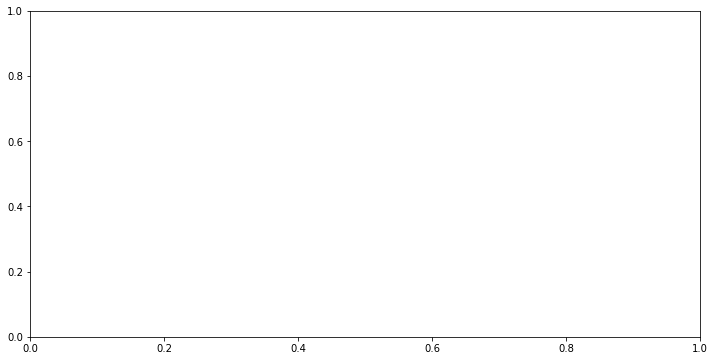

In [20]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(predsarray[:, 0], bins = 50, alpha=0.75, label='Probability of through')
ax.hist(predsarray[:, 1], bins = 50, alpha=0.75, label='Probability of stopped')
ax.legend()
plt.show()

In [21]:
ROC_plot(predsarray, targs)

NameError: name 'predsarray' is not defined

In [22]:
unique_preds, counts_preds = np.unique(predsarray[:,0], return_counts=True)
print('Unique through predictions: ', np.round(unique_preds, 3))
print('Counts through predictions: ', counts_preds)

NameError: name 'predsarray' is not defined

In [23]:
unique_targs, counts_targs = np.unique(predsarray[:,1], return_counts=True)
print('Unique stopped predictions: ', np.round(unique_targs, 3))
print('Counts stopped predictions: ', counts_targs)

NameError: name 'predsarray' is not defined

In [24]:
guesses = np.zeros((N_preds,1))
for i in range(N_preds):
    guesses[i] = np.argmax(preds[0][i])

unique_preds, counts_preds = np.unique(guesses, return_counts=True)
print('Unique predictions: ', unique_preds)
print('Counts predictions: ', counts_preds)

NameError: name 'preds' is not defined

In [25]:
unique_targs, counts_targs = np.unique(targs, return_counts=True)
print('Unique targets: ', unique_targs)
print('Counts targets: ', counts_targs)

NameError: name 'targs' is not defined